# Frame1-from-frame2 with UNet clean + UNet++ bolus head


In [2]:
from pathlib import Path
from collections import defaultdict
import random
import re
import math

import cv2
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

DATA_ROOT = Path('.')
IMAGES_DIR = DATA_ROOT / 'images'
MASKS_DIR = DATA_ROOT / 'masks'

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4
NUM_WORKERS = 0
NUM_EPOCHS = 40
AUGMENT_TRAIN = False

# Clean UNet hyperparams
CLEAN_FEATURES = (32, 64, 128)
CLEAN_LR = 1e-3

# Bolus UNet++ hyperparams
FUSION_FEATURES = (64, 128, 256)
FUSION_LR = 1e-3
CLEAN_FINE_LR = 1e-4
ATTN_EPOCHS = 40

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PIN_MEMORY = device.type == 'cuda'

print('Using device:', device)


Using device: cuda


In [3]:
FILENAME_PATTERN = re.compile(r"^(?P<prefix>[A-Za-z0-9]{6})(?P<frame>\d+)_")


def parse_frame_key(path: Path):
    match = FILENAME_PATTERN.match(path.stem)
    if not match:
        raise ValueError(f"Unexpected filename: {path.name}")
    return match.group("prefix"), int(match.group("frame"))


def load_gray(path: Path) -> np.ndarray:
    image = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(path)
    return image


def collect_frame_pairs(images_dir: Path, masks_dir: Path) -> pd.DataFrame:
    grouped = defaultdict(list)
    for img_path in images_dir.glob("*.png"):
        try:
            prefix, frame_idx = parse_frame_key(img_path)
        except ValueError:
            continue
        grouped[prefix].append((frame_idx, img_path))

    rows = []
    for prefix, frames in grouped.items():
        frames.sort(key=lambda x: x[0])
        for (idx_prev, path_prev), (_, path_next) in zip(frames, frames[1:]):
            mask_prev = masks_dir / path_prev.name
            if not mask_prev.exists():
                continue
            rows.append(
                {
                    "frame1": path_prev,
                    "frame2": path_next,
                    "mask1": mask_prev,
                    "sequence": prefix,
                    "frame_idx": idx_prev,
                }
            )
    return pd.DataFrame(rows)


pairs_df = collect_frame_pairs(IMAGES_DIR, MASKS_DIR)
print(f"Total pairs: {len(pairs_df)} from {pairs_df['sequence'].nunique()} sequences")
if len(pairs_df) == 0:
    raise RuntimeError("No frame pairs found. Confirm IMAGES_DIR and MASKS_DIR are populated.")
pairs_df.head()

Total pairs: 6337 from 87 sequences


,frame1,frame2,mask1,sequence,frame_idx
0,images\ns050a196_resized_512.png,images\ns050a198_resized_512.png,masks\ns050a196_resized_512.png,ns050a,196
1,images\ns050a198_resized_512.png,images\ns050a200_resized_512.png,masks\ns050a198_resized_512.png,ns050a,198
2,images\ns050a200_resized_512.png,images\ns050a202_resized_512.png,masks\ns050a200_resized_512.png,ns050a,200
3,images\ns050a202_resized_512.png,images\ns050a204_resized_512.png,masks\ns050a202_resized_512.png,ns050a,202
4,images\ns050a204_resized_512.png,images\ns050a206_resized_512.png,masks\ns050a204_resized_512.png,ns050a,204


In [4]:
seqs = pairs_df["sequence"].unique()
train_seq, temp_seq = train_test_split(seqs, test_size=0.30, random_state=SEED, shuffle=True)
val_seq, test_seq = train_test_split(temp_seq, test_size=0.50, random_state=SEED, shuffle=True)

splits = {
    "train": pairs_df[pairs_df["sequence"].isin(train_seq)].reset_index(drop=True),
    "val": pairs_df[pairs_df["sequence"].isin(val_seq)].reset_index(drop=True),
    "test": pairs_df[pairs_df["sequence"].isin(test_seq)].reset_index(drop=True),
}

for name, df in splits.items():
    print(f"{name}: {len(df)} samples | sequences: {df['sequence'].nunique()}")

train: 4761 samples | sequences: 60
val: 843 samples | sequences: 13
test: 733 samples | sequences: 14


In [5]:
class FramePairDataset(Dataset):
    def __init__(self, df: pd.DataFrame, augment: bool = False):
        self.df = df.reset_index(drop=True)
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        frame1 = load_gray(row["frame1"]).astype(np.float32) / 255.0
        frame2 = load_gray(row["frame2"]).astype(np.float32) / 255.0
        mask1 = load_gray(row["mask1"])
        mask1 = (mask1 > 0).astype(np.float32)

        if self.augment:
            if random.random() < 0.5:
                frame1 = np.flip(frame1, axis=1).copy()
                frame2 = np.flip(frame2, axis=1).copy()
                mask1 = np.flip(mask1, axis=1).copy()
            if random.random() < 0.5:
                frame1 = np.flip(frame1, axis=0).copy()
                frame2 = np.flip(frame2, axis=0).copy()
                mask1 = np.flip(mask1, axis=0).copy()

        frame1_t = torch.from_numpy(frame1).unsqueeze(0)
        frame2_t = torch.from_numpy(frame2).unsqueeze(0)
        mask1_t = torch.from_numpy(mask1).unsqueeze(0)
        return frame2_t, frame1_t, mask1_t


loader_kwargs = dict(num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

data_loaders = {
    "train": DataLoader(FramePairDataset(splits["train"], augment=AUGMENT_TRAIN), batch_size=TRAIN_BATCH_SIZE, shuffle=True, **loader_kwargs),
    "val": DataLoader(FramePairDataset(splits["val"]), batch_size=VAL_BATCH_SIZE, shuffle=False, **loader_kwargs),
    "test": DataLoader(FramePairDataset(splits["test"]), batch_size=VAL_BATCH_SIZE, shuffle=False, **loader_kwargs),
}

for name, loader in data_loaders.items():
    batch = next(iter(loader))
    f2, f1, m1 = batch
    print(name, "batch shapes:", f2.shape, f1.shape, m1.shape)

train batch shapes: torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512])
val batch shapes: torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512])
test batch shapes: torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512])


In [6]:
def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class TinyUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=(16, 32, 64)):
        super().__init__()
        self.downs = nn.ModuleList()
        self.pools = nn.ModuleList()
        ch = in_channels
        for feat in features:
            self.downs.append(ConvBlock(ch, feat))
            self.pools.append(nn.MaxPool2d(2))
            ch = feat

        self.bottleneck = ConvBlock(features[-1], features[-1] * 2)

        self.upconvs = nn.ModuleList()
        self.dec_blocks = nn.ModuleList()
        decoder_in = features[-1] * 2
        for feat in reversed(features):
            self.upconvs.append(nn.ConvTranspose2d(decoder_in, feat, kernel_size=2, stride=2))
            self.dec_blocks.append(ConvBlock(feat * 2, feat))
            decoder_in = feat

        self.final = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skips = []
        for down, pool in zip(self.downs, self.pools):
            x = down(x)
            skips.append(x)
            x = pool(x)

        x = self.bottleneck(x)
        for upconv, dec, skip in zip(self.upconvs, self.dec_blocks, reversed(skips)):
            x = upconv(x)
            if x.shape[-2:] != skip.shape[-2:]:
                x = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=False)
            x = torch.cat([skip, x], dim=1)
            x = dec(x)

        return torch.sigmoid(self.final(x))


class UNetPlusPlus(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, features=(32, 64, 128)):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        f0, f1, f2 = features

        self.x0_0 = ConvBlock(in_channels, f0)
        self.x1_0 = ConvBlock(f0, f1)
        self.x2_0 = ConvBlock(f1, f2)

        self.x0_1 = ConvBlock(f0 + f1, f0)
        self.x1_1 = ConvBlock(f1 + f2, f1)
        self.x0_2 = ConvBlock(f0 * 2 + f1, f0)

        self.final = nn.Conv2d(f0, out_channels, kernel_size=1)

    def forward(self, x):
        x0_0 = self.x0_0(x)
        x1_0 = self.x1_0(self.pool(x0_0))
        x2_0 = self.x2_0(self.pool(x1_0))

        x0_1 = self.x0_1(torch.cat([x0_0, F.interpolate(x1_0, size=x0_0.shape[-2:], mode='bilinear', align_corners=False)], dim=1))
        x1_1 = self.x1_1(torch.cat([x1_0, F.interpolate(x2_0, size=x1_0.shape[-2:], mode='bilinear', align_corners=False)], dim=1))

        x0_2 = self.x0_2(torch.cat([
            x0_0,
            x0_1,
            F.interpolate(x1_1, size=x0_0.shape[-2:], mode='bilinear', align_corners=False),
        ], dim=1))

        return self.final(x0_2)


# instantiate models
clean_model = TinyUNet(in_channels=1, out_channels=1, features=CLEAN_FEATURES).to(device)
fusion_model = UNetPlusPlus(in_channels=2, out_channels=1, features=FUSION_FEATURES).to(device)
model = clean_model  # alias for clean stage

print(f"Clean params: {count_params(clean_model)/1e6:.2f}M")
print(f"Fusion params: {count_params(fusion_model)/1e6:.2f}M")
print(f"TOTAL params: {(count_params(clean_model) + count_params(fusion_model))/1e6:.2f}M")


Clean params: 1.93M
Fusion params: 2.07M
TOTAL params: 4.00M


In [7]:
l1_loss = nn.L1Loss()

def ssim_like(x, y):
    return ((x - y).pow(2).mean()).sqrt()

def mse_loss(pred, target):
    return (pred - target).pow(2).mean()

def psnr_from_mse(mse_tensor):
    return (10 * torch.log10(1.0 / torch.clamp(mse_tensor, min=1e-10))).mean()

def to_device(batch):
    return [b.to(device) for b in batch]


In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr=CLEAN_LR, weight_decay=1e-4)
history = []
best_state = None
best_val_loss = float('inf')

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    train_losses = []

    for frame2, frame1, _ in tqdm(data_loaders['train'], desc=f"Epoch {epoch} [train]"):
        frame2, frame1 = [t.to(device) for t in (frame2, frame1)]
        pred = model(frame2)
        loss = l1_loss(pred, frame1) + 0.1 * ssim_like(pred, frame1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    train_loss = float(np.mean(train_losses)) if train_losses else float('nan')

    model.eval()
    val_losses = []
    val_psnr = []
    with torch.no_grad():
        for frame2, frame1, _ in data_loaders['val']:
            frame2, frame1 = [t.to(device) for t in (frame2, frame1)]
            pred = model(frame2)
            l1 = l1_loss(pred, frame1)
            mse = mse_loss(pred, frame1)
            val_losses.append(l1.item())
            val_psnr.append(psnr_from_mse(mse).item())

    val_loss = float(np.mean(val_losses)) if val_losses else float('nan')
    val_psnr_mean = float(np.mean(val_psnr)) if val_psnr else float('nan')
    history.append(dict(epoch=epoch, train_loss=train_loss, val_loss=val_loss, val_psnr=val_psnr_mean))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}

    print(f"Epoch {epoch}: train L1={train_loss:.4f} | val L1={val_loss:.4f} | val PSNR={val_psnr_mean:.2f}")

print('Best val L1:', best_val_loss)


Epoch 1 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 1: train L1=0.0187 | val L1=0.0095 | val PSNR=36.38


Epoch 2 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 2: train L1=0.0100 | val L1=0.0080 | val PSNR=38.35


Epoch 3 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 3: train L1=0.0088 | val L1=0.0067 | val PSNR=39.30


Epoch 4 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 4: train L1=0.0080 | val L1=0.0083 | val PSNR=38.54


Epoch 5 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 5: train L1=0.0080 | val L1=0.0065 | val PSNR=39.15


Epoch 6 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 6: train L1=0.0078 | val L1=0.0088 | val PSNR=35.93


Epoch 7 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 7: train L1=0.0075 | val L1=0.0085 | val PSNR=37.27


Epoch 8 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 8: train L1=0.0075 | val L1=0.0074 | val PSNR=38.62


Epoch 9 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 9: train L1=0.0073 | val L1=0.0058 | val PSNR=40.22


Epoch 10 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 10: train L1=0.0071 | val L1=0.0094 | val PSNR=36.57


Epoch 11 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 11: train L1=0.0072 | val L1=0.0061 | val PSNR=39.73


Epoch 12 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 12: train L1=0.0069 | val L1=0.0060 | val PSNR=40.15


Epoch 13 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 13: train L1=0.0070 | val L1=0.0091 | val PSNR=37.03


Epoch 14 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 14: train L1=0.0070 | val L1=0.0060 | val PSNR=39.78


Epoch 15 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 15: train L1=0.0069 | val L1=0.0072 | val PSNR=38.32


Epoch 16 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 16: train L1=0.0068 | val L1=0.0057 | val PSNR=40.24


Epoch 17 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 17: train L1=0.0067 | val L1=0.0070 | val PSNR=38.72


Epoch 18 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 18: train L1=0.0067 | val L1=0.0080 | val PSNR=38.46


Epoch 19 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 19: train L1=0.0067 | val L1=0.0071 | val PSNR=38.20


Epoch 20 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 20: train L1=0.0067 | val L1=0.0068 | val PSNR=38.85


Epoch 21 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 21: train L1=0.0066 | val L1=0.0060 | val PSNR=39.92


Epoch 22 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 22: train L1=0.0065 | val L1=0.0076 | val PSNR=38.43


Epoch 23 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 23: train L1=0.0065 | val L1=0.0069 | val PSNR=39.67


Epoch 24 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 24: train L1=0.0066 | val L1=0.0060 | val PSNR=40.04


Epoch 25 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 25: train L1=0.0065 | val L1=0.0067 | val PSNR=38.94


Epoch 26 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 26: train L1=0.0064 | val L1=0.0067 | val PSNR=38.98


Epoch 27 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 27: train L1=0.0066 | val L1=0.0064 | val PSNR=39.36


Epoch 28 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 28: train L1=0.0064 | val L1=0.0071 | val PSNR=38.51


Epoch 29 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 29: train L1=0.0064 | val L1=0.0062 | val PSNR=39.79


Epoch 30 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 30: train L1=0.0064 | val L1=0.0058 | val PSNR=40.11


Epoch 31 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 31: train L1=0.0064 | val L1=0.0056 | val PSNR=40.36


Epoch 32 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 32: train L1=0.0064 | val L1=0.0088 | val PSNR=36.46


Epoch 33 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 33: train L1=0.0064 | val L1=0.0063 | val PSNR=39.64


Epoch 34 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 34: train L1=0.0064 | val L1=0.0061 | val PSNR=40.08


Epoch 35 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 35: train L1=0.0063 | val L1=0.0075 | val PSNR=38.11


Epoch 36 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 36: train L1=0.0063 | val L1=0.0074 | val PSNR=38.12


Epoch 37 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 37: train L1=0.0063 | val L1=0.0065 | val PSNR=39.23


Epoch 38 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 38: train L1=0.0063 | val L1=0.0070 | val PSNR=38.96


Epoch 39 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 39: train L1=0.0063 | val L1=0.0057 | val PSNR=40.10


Epoch 40 [train]:   0%|          | 0/1191 [00:00<?, ?it/s]

Epoch 40: train L1=0.0063 | val L1=0.0063 | val PSNR=39.55
Best val L1: 0.005623635091108239


Test L1: 0.0056 | Test PSNR: 40.23


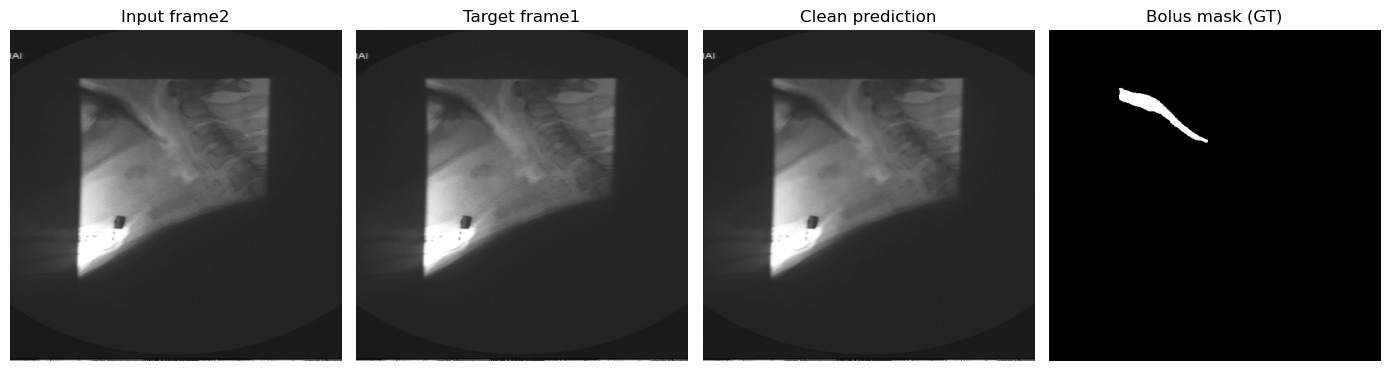

In [21]:
if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)

model.eval()
test_losses = []
test_psnr = []
with torch.no_grad():
    for frame2, frame1, _ in data_loaders['test']:
        frame2, frame1 = [t.to(device) for t in (frame2, frame1)]
        pred = model(frame2)
        l1 = l1_loss(pred, frame1)
        mse = mse_loss(pred, frame1)
        test_losses.append(l1.item())
        test_psnr.append(psnr_from_mse(mse).item())

print(
    f"Test L1: {float(np.mean(test_losses)) if test_losses else float('nan'):.4f} | "
    f"Test PSNR: {float(np.mean(test_psnr)) if test_psnr else float('nan'):.2f}"
)

# quick qualitative sample (uses test split when available)
target_loader = data_loaders['test'] if len(splits['test']) else data_loaders['val']
with torch.no_grad():
    sample_batch = next(iter(target_loader))
    frame2, frame1, mask1 = [t.to(device) for t in sample_batch]
    pred = model(frame2).cpu().numpy()
    frame2 = frame2.cpu().numpy()
    frame1 = frame1.cpu().numpy()
    mask1 = mask1.cpu().numpy()

idx = 0
fig, axes = plt.subplots(1, 4, figsize=(14, 4))
axes[0].imshow(frame2[idx, 0], cmap='gray')
axes[0].set_title('Input frame2')
axes[1].imshow(frame1[idx, 0], cmap='gray')
axes[1].set_title('Target frame1')
axes[2].imshow(pred[idx, 0], cmap='gray', vmin=0, vmax=1)
axes[2].set_title('Clean prediction')
axes[3].imshow(mask1[idx, 0], cmap='gray')
axes[3].set_title('Bolus mask (GT)')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()


In [22]:
torch.save(model.state_dict(), 'unet_clean_weights.pth')


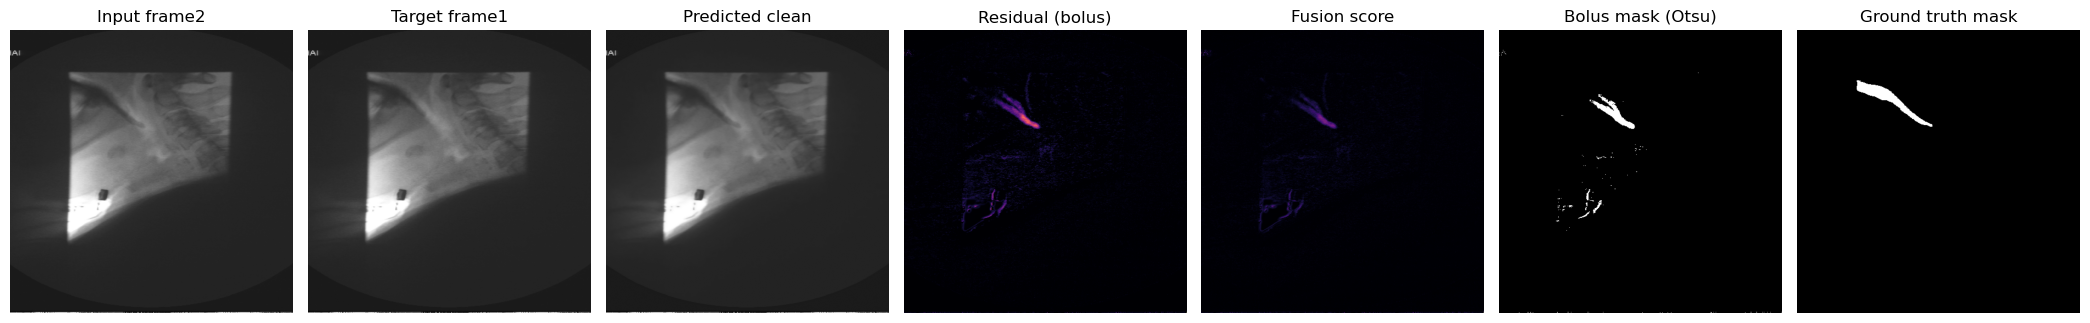

In [23]:
# Load saved clean-frame weights and estimate bolus mask via residual heuristics
CKPT_PATH = Path('unet_clean_weights.pth')

if not CKPT_PATH.exists():
    raise FileNotFoundError(f"Checkpoint not found: {CKPT_PATH}")

state = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()

# prefer test loader if available
target_loader = data_loaders['test'] if len(splits['test']) else data_loaders['val']
with torch.no_grad():
    frame2, frame1, mask1 = [t.to(device) for t in next(iter(target_loader))]
    pred_clean = model(frame2).clamp(0, 1)
    residual = (frame1 - pred_clean).clamp(min=0)  # expected bolus contribution
    fusion = (residual + (frame2 - pred_clean).abs()).clamp(0, 1)

idx = 0
res_img = (residual[idx, 0].cpu().numpy() * 255).astype(np.uint8)
_, bolus_mask = cv2.threshold(res_img, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

fig, axes = plt.subplots(1, 7, figsize=(21, 4))
axes[0].imshow(frame2[idx, 0].cpu(), cmap='gray'); axes[0].set_title('Input frame2')
axes[1].imshow(frame1[idx, 0].cpu(), cmap='gray'); axes[1].set_title('Target frame1')
axes[2].imshow(pred_clean[idx, 0].cpu(), cmap='gray', vmin=0, vmax=1); axes[2].set_title('Predicted clean')
axes[3].imshow(residual[idx, 0].cpu(), cmap='magma'); axes[3].set_title('Residual (bolus)')
axes[4].imshow(fusion[idx, 0].cpu(), cmap='magma'); axes[4].set_title('Fusion score')
axes[5].imshow(bolus_mask, cmap='gray'); axes[5].set_title('Bolus mask (Otsu)')
axes[6].imshow(mask1[idx, 0].cpu(), cmap='gray'); axes[6].set_title('Ground truth mask')
for ax in axes: ax.axis('off')
plt.tight_layout()
plt.show()


Fusion params: 2.07M


[Fusion] Epoch 1:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 1 BCE: 0.0303 | Dice: 0.1817


[Fusion] Epoch 2:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 2 BCE: 0.0653 | Dice: 0.7649


[Fusion] Epoch 3:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 3 BCE: 0.0066 | Dice: 0.1633


[Fusion] Epoch 4:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 4 BCE: 0.0159 | Dice: 0.4897


[Fusion] Epoch 5:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 5 BCE: 0.0210 | Dice: 0.1197


[Fusion] Epoch 6:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 6 BCE: 0.0125 | Dice: 0.2011


[Fusion] Epoch 7:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 7 BCE: 0.1626 | Dice: 0.4792


[Fusion] Epoch 8:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 8 BCE: 0.0163 | Dice: 0.1095


[Fusion] Epoch 9:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 9 BCE: 0.0085 | Dice: 0.1279


[Fusion] Epoch 10:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 10 BCE: 0.0112 | Dice: 0.1029


[Fusion] Epoch 11:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 11 BCE: 0.0067 | Dice: 0.4298


[Fusion] Epoch 12:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 12 BCE: 0.0173 | Dice: 0.1082


[Fusion] Epoch 13:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 13 BCE: 0.0153 | Dice: 0.1223


[Fusion] Epoch 14:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 14 BCE: 0.0054 | Dice: 0.3067


[Fusion] Epoch 15:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 15 BCE: 0.0061 | Dice: 0.1252


[Fusion] Epoch 16:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 16 BCE: 0.0218 | Dice: 0.1655


[Fusion] Epoch 17:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 17 BCE: 0.0044 | Dice: 0.0784


[Fusion] Epoch 18:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 18 BCE: 0.0085 | Dice: 0.1403


[Fusion] Epoch 19:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 19 BCE: 0.0082 | Dice: 0.1584


[Fusion] Epoch 20:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 20 BCE: 0.0129 | Dice: 0.1147


[Fusion] Epoch 21:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 21 BCE: 0.0143 | Dice: 0.1133


[Fusion] Epoch 22:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 22 BCE: 0.0051 | Dice: 0.1534


[Fusion] Epoch 23:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 23 BCE: 0.0049 | Dice: 0.3663


[Fusion] Epoch 24:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 24 BCE: 0.0064 | Dice: 0.2640


[Fusion] Epoch 25:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 25 BCE: 0.0155 | Dice: 0.1277


[Fusion] Epoch 26:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 26 BCE: 0.0063 | Dice: 0.3420


[Fusion] Epoch 27:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 27 BCE: 0.0172 | Dice: 0.2458


[Fusion] Epoch 28:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 28 BCE: 0.0234 | Dice: 0.1206


[Fusion] Epoch 29:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 29 BCE: 0.0195 | Dice: 0.2415


[Fusion] Epoch 30:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 30 BCE: 0.0001 | Dice: 1.0000


[Fusion] Epoch 31:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 31 BCE: 0.0068 | Dice: 0.4812


[Fusion] Epoch 32:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 32 BCE: 0.0158 | Dice: 0.1406


[Fusion] Epoch 33:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 33 BCE: 0.0031 | Dice: 1.0000


[Fusion] Epoch 34:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 34 BCE: 0.0377 | Dice: 0.1295


[Fusion] Epoch 35:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 35 BCE: 0.0077 | Dice: 0.1939


[Fusion] Epoch 36:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 36 BCE: 0.0018 | Dice: 0.1296


[Fusion] Epoch 37:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 37 BCE: 0.0122 | Dice: 0.1173


[Fusion] Epoch 38:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 38 BCE: 0.0334 | Dice: 0.9999


[Fusion] Epoch 39:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 39 BCE: 0.0173 | Dice: 0.0896


[Fusion] Epoch 40:   0%|          | 0/1191 [00:00<?, ?it/s]

[Fusion] Epoch 40 BCE: 0.0170 | Dice: 0.3586


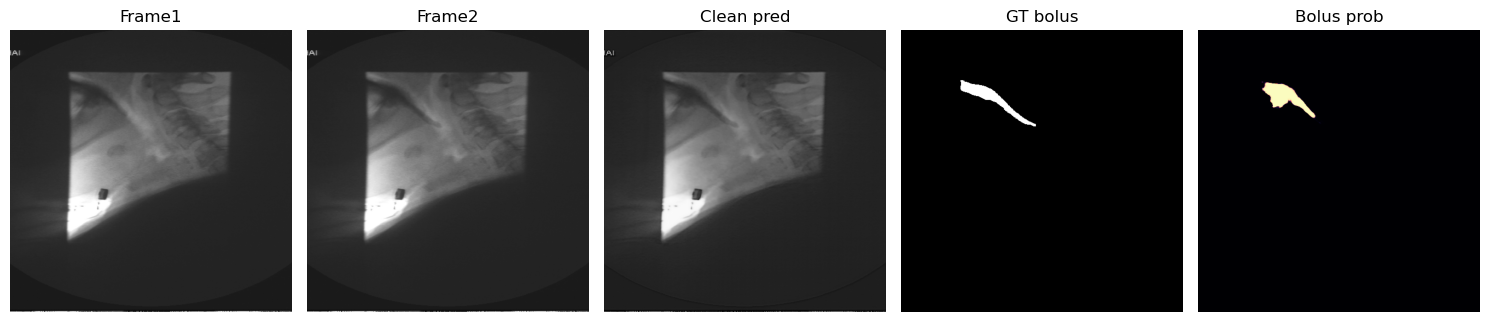

In [24]:
# Fusion model: frame1 + clean prediction -> bolus mask (joint fine-tuning)
fusion_model = UNetPlusPlus(in_channels=2, out_channels=1, features=FUSION_FEATURES).to(device)
attn_model = fusion_model

attn_optimizer = torch.optim.AdamW(
    [
        {'params': attn_model.parameters(), 'lr': FUSION_LR},
        {'params': model.parameters(), 'lr': CLEAN_FINE_LR},
    ],
    weight_decay=1e-4,
)
bce_loss = nn.BCEWithLogitsLoss()

def soft_dice_loss(logits, target, eps: float = 1e-6):
    p = torch.sigmoid(logits)
    inter = (p * target).sum(dim=(1, 2, 3))
    denom = p.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3))
    return 1 - ((2 * inter + eps) / (denom + eps)).mean()

print(f"Fusion params: {count_params(attn_model)/1e6:.2f}M")

for epoch in range(1, ATTN_EPOCHS + 1):
    model.train()
    attn_model.train()
    losses = []
    progress = tqdm(data_loaders['train'], desc=f"[Fusion] Epoch {epoch}", leave=False)
    for frame2, frame1, mask1 in progress:
        frame2, frame1, mask1 = [t.to(device) for t in (frame2, frame1, mask1)]
        clean_pred = model(frame2).clamp(0, 1)
        logits = attn_model(torch.cat([frame1, clean_pred], dim=1))

        loss_bce = bce_loss(logits, mask1)
        loss_dice = soft_dice_loss(logits, mask1)
        loss = loss_bce + 0.8 * loss_dice   #### 

        attn_optimizer.zero_grad()
        loss.backward()
        attn_optimizer.step()
        losses.append(loss.item())
        progress.set_postfix(loss=f"{loss.item():.4f}")
    print(f"[Fusion] Epoch {epoch} BCE: {loss_bce.item():.4f} | Dice: {loss_dice.item():.4f}")

# quick eval/visualization
model.eval()
attn_model.eval()
target_loader = data_loaders['test'] if len(splits['test']) else data_loaders['val']
with torch.no_grad():
    frame2, frame1, mask1 = [t.to(device) for t in next(iter(target_loader))]
    clean_pred = model(frame2).clamp(0, 1)
    bolus_logits = attn_model(torch.cat([frame1, clean_pred], dim=1))
    bolus_prob = torch.sigmoid(bolus_logits)

idx = 0
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
axes[0].imshow(frame1[idx, 0].cpu(), cmap='gray'); axes[0].set_title('Frame1')
axes[1].imshow(frame2[idx, 0].cpu(), cmap='gray'); axes[1].set_title('Frame2')
axes[2].imshow(clean_pred[idx, 0].cpu(), cmap='gray', vmin=0, vmax=1); axes[2].set_title('Clean pred')
axes[3].imshow(mask1[idx, 0].cpu(), cmap='gray'); axes[3].set_title('GT bolus')
axes[4].imshow(bolus_prob[idx, 0].cpu(), cmap='magma', vmin=0, vmax=1); axes[4].set_title('Bolus prob')
for ax in axes: ax.axis('off')
plt.tight_layout()
plt.show()


In [25]:
torch.save(attn_model.state_dict(), 'unetpp_fusion_weights.pth')


In [16]:
# Manual fusion step: run one extra epoch and free memory before evaluation
import gc
from pathlib import Path

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# reload last saved weights (clean + fusion) before manual step
clean_ckpt = Path('unet_clean_weights.pth')
fusion_ckpt = Path('unetpp_fusion_manual_epoch1.pth')
fusion_model = UNetPlusPlus(in_channels=2, out_channels=1, features=FUSION_FEATURES).to(device)
clean_model = TinyUNet(in_channels=1, out_channels=1, features=CLEAN_FEATURES).to(device)
attn_model = fusion_model
model = clean_model

attn_optimizer = torch.optim.AdamW(
    [
        {'params': attn_model.parameters(), 'lr': FUSION_LR},
        {'params': model.parameters(), 'lr': CLEAN_FINE_LR},
    ],
    weight_decay=1e-4,
)

bce_loss = nn.BCEWithLogitsLoss()

def soft_dice_loss(logits, target, eps: float = 1e-6):
    p = torch.sigmoid(logits)
    inter = (p * target).sum(dim=(1, 2, 3))
    denom = p.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3))
    return 1 - ((2 * inter + eps) / (denom + eps)).mean()

if clean_ckpt.exists():
    model.load_state_dict(torch.load(clean_ckpt, map_location=device))
    model.to(device)
if fusion_ckpt.exists():
    attn_model.load_state_dict(torch.load(fusion_ckpt, map_location=device))
    attn_model.to(device)

manual_epoch = globals().get('manual_epoch', 0) + 1
globals()['manual_epoch'] = manual_epoch
model.train(); attn_model.train()
losses = []
progress = tqdm(data_loaders['train'], desc=f'[Manual Fusion] Epoch {manual_epoch}', leave=False)
for frame2, frame1, mask1 in progress:
    frame2, frame1, mask1 = [t.to(device) for t in (frame2, frame1, mask1)]
    clean_pred = model(frame2).clamp(0, 1)
    logits = attn_model(torch.cat([frame1, clean_pred], dim=1))
    loss_bce = bce_loss(logits, mask1)
    loss_dice = soft_dice_loss(logits, mask1)
    loss = loss_bce + 0.5 * loss_dice
    attn_optimizer.zero_grad()
    loss.backward()
    attn_optimizer.step()
    losses.append(loss.item())
    progress.set_postfix(loss=f'{loss.item():.4f}')
print(f'[Manual Fusion] Epoch {manual_epoch} BCE: {loss_bce.item():.4f} | Dice: {loss_dice.item():.4f}')
print(f'Avg loss: {float(np.mean(losses)) if losses else float("nan"):.4f}')

# Optionally save a checkpoint after a good manual epoch
# torch.save(attn_model.state_dict(), f'unetpp_fusion_manual_epoch{manual_epoch}.pth')


[Manual Fusion] Epoch 4:   0%|          | 0/1191 [00:00<?, ?it/s]

[Manual Fusion] Epoch 4 BCE: 0.0052 | Dice: 0.1024
Avg loss: 0.0958


In [17]:
torch.save(attn_model.state_dict(), f'unetpp_fusion_manual_epoch1.pth')

In [18]:
import gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Evaluate fusion model: IoU, Dice (DSC), AUC
from sklearn.metrics import roc_auc_score

attn_model.eval()
target_loader = data_loaders['test'] if len(splits['test']) else data_loaders['val']

total_iou = []
total_dice = []
all_probs = []
all_targets = []

with torch.no_grad():
    for frame2, frame1, mask1 in target_loader:
        frame2, frame1, mask1 = [t.to(device) for t in (frame2, frame1, mask1)]
        clean_pred = model(frame2).clamp(0, 1)
        logits = attn_model(torch.cat([frame1, clean_pred], dim=1))
        prob = torch.sigmoid(logits).clamp(0, 1)

        pred_bin = (prob >= 0.5).float()
        intersection = (pred_bin * mask1).sum(dim=(1, 2, 3))
        union = pred_bin.sum(dim=(1, 2, 3)) + mask1.sum(dim=(1, 2, 3)) - intersection
        dice = (2 * intersection) / (pred_bin.sum(dim=(1, 2, 3)) + mask1.sum(dim=(1, 2, 3))).clamp_min(1e-6)
        iou = intersection / union.clamp_min(1e-6)

        total_iou.extend(iou.cpu().numpy().tolist())
        total_dice.extend(dice.cpu().numpy().tolist())
        all_probs.append(prob.cpu().float().numpy().reshape(-1))
        all_targets.append(mask1.cpu().float().numpy().reshape(-1))

all_probs = np.concatenate(all_probs).astype(np.float32, copy=False) if all_probs else np.array([], dtype=np.float32)
all_targets = np.concatenate(all_targets).astype(np.float32, copy=False) if all_targets else np.array([], dtype=np.float32)

if all_probs.size == 0:
    auc = float('nan')
elif np.unique(all_targets).size < 2:
    auc = float('nan')
else:
    auc = roc_auc_score(all_targets, all_probs)

print(
    f"Fusion IoU: {float(np.mean(total_iou)) if total_iou else float('nan'):.4f} | "
    f"Fusion Dice: {float(np.mean(total_dice)) if total_dice else float('nan'):.4f} | "
    f"Fusion AUC: {auc if not np.isnan(auc) else float('nan'):.4f}"
)


Fusion IoU: 0.4706 | Fusion Dice: 0.6019 | Fusion AUC: 0.9899
